**Installing the appropiate version of OpenCV**

In [14]:
!pip install opencv-contrib-python==3.4.2.16

<h2>Working on "Gravel Quarry" dataset</h2>

**Importing packages**

In [16]:
import cv2
import numpy as np

**Uploading 2 images**

In [59]:
img_ = cv2.imread('/content/IX-01-61737_0029_0053.JPG')
img_ = cv2.resize(img_, (0,0), fx=1, fy=1)
img1 = cv2.cvtColor(img_,cv2.COLOR_BGR2GRAY)
img = cv2.imread('/content/IX-01-61737_0029_0054.JPG')
img = cv2.resize(img, (0,0), fx=1, fy=1)
img2 = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

<h4>Finding the key points and descriptors with SIFT<h4>

In [60]:
sift = cv2.xfeatures2d.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

**Displaying the output on 1st image**

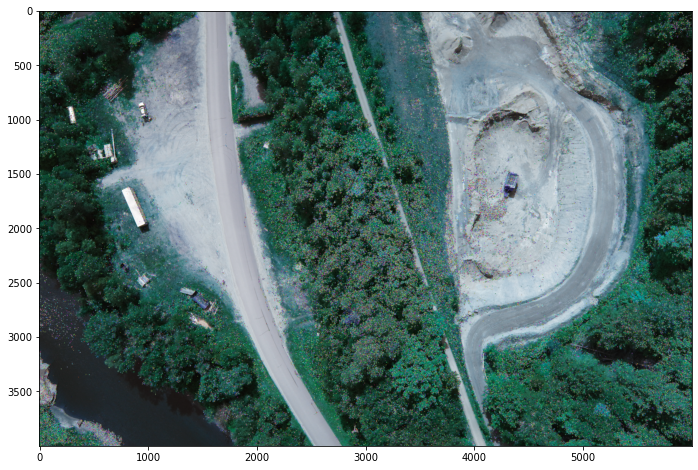

In [61]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
# cv2.imshow('original_image_left_keypoints',cv2.drawKeypoints(img_,kp1,None))
plt.imshow(cv2.drawKeypoints(img_,kp1,None))

<h3>Finding the 'Matching' points between two images</h3>

<h4>FLANN matcher</h4>

In [20]:
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
match = cv2.FlannBasedMatcher(index_params, search_params)
matches = match.knnMatch(des1,des2,k=2)

<h4>BFMatcher matcher</h4>

In [62]:
match = cv2.BFMatcher()
matches = match.knnMatch(des1,des2,k=2)

Both will perform the same way and will give same output

In [67]:
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

**Output image with matches drawn**

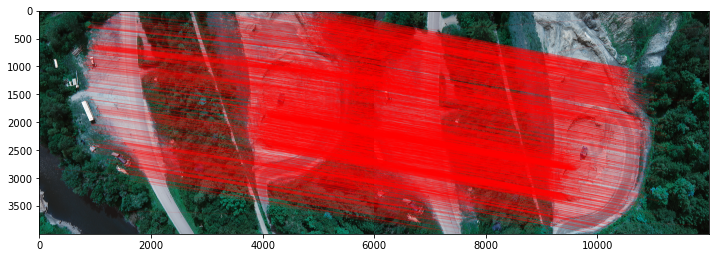

In [69]:
draw_params = dict(matchColor = (255,0,0), # draw matches in red color
                   singlePointColor = None,
                   flags = 2)
img3 = cv2.drawMatches(img_,kp1,img,kp2,good,None,**draw_params)
# cv2.imshow("original_image_drawMatches.jpg", img3)
plt.figure(figsize=(12,10))
plt.imshow(img3)

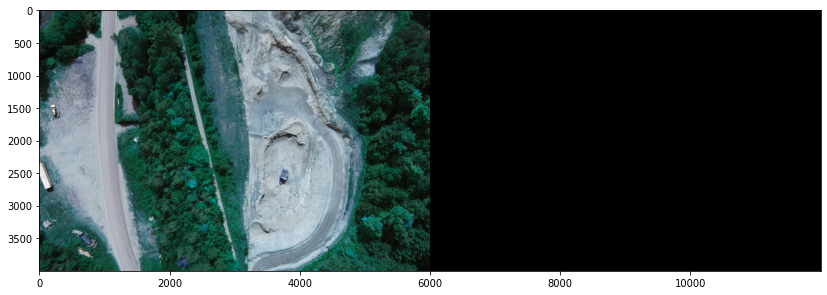

In [74]:
MIN_MATCH_COUNT = 10
if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, M)
    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    #cv2.imshow("original_image_overlapping.jpg", img2)
else:
    print("Not enought matches are found - %d/%d", (len(good)/MIN_MATCH_COUNT))
dst = cv2.warpPerspective(img_,M,(img.shape[1] + img_.shape[1], img.shape[0]))
dst[0:img.shape[0],0:img.shape[1]] = img
# cv2.imshow("original_image_stitched.jpg", dst)
plt.figure(figsize=(14,10))
plt.imshow(dst)

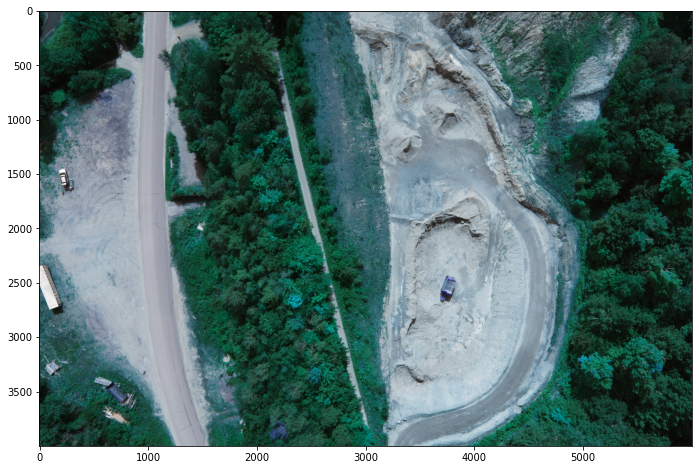

In [77]:
def trim(frame):
    #crop top
    if not np.sum(frame[0]):
        return trim(frame[1:])
    #crop top
    if not np.sum(frame[-1]):
        return trim(frame[:-2])
    #crop top
    if not np.sum(frame[:,0]):
        return trim(frame[:,1:])
    #crop top
    if not np.sum(frame[:,-1]):
        return trim(frame[:,:-2])
    return frame

def crop(image):
  y_nonzero, x_nonzero, _ = np.nonzero(image)
  return image[np.min(y_nonzero):np.max(y_nonzero), np.min(x_nonzero):np.max(x_nonzero)]

plt.figure(figsize=(12,8))
plt.imshow(crop(dst))

It seems the output will not be as expected. But, we can notice it is performing our main motive - 'Homography' and 'Matching between images'

<h2>Working on "Dam Inspection" dataset</h2>

**Creating the Matcher class**

This deals with:
  1. Feature extraction
  2. Matching correspondences between images

In [19]:
import cv2
import numpy as np

class matchers:
  def __init__(self):
    self.surf = cv2.xfeatures2d.SURF_create()
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=0, trees=5) 
    search_params = dict(checks=50)
    self.flann = cv2.FlannBasedMatcher(index_params, search_params)

  def match(self, i1, i2, direction=None): 
    imageSet1 = self.getSURFFeatures(i1) 
    imageSet2 = self.getSURFFeatures(i2) 
    print("Direction : ", direction) 
    matches = self.flann.knnMatch(imageSet2['des'], imageSet1['des'], k=2)
    good = []
    for i , (m, n) in enumerate(matches): 
      if m.distance < 0.7*n.distance:
        good.append((m.trainIdx, m.queryIdx))

    if len(good) > 4:
      pointsCurrent = imageSet2['kp'] 
      pointsPrevious = imageSet1['kp']

      matchedPointsCurrent = np.float32( [pointsCurrent[i].pt for (_, i) in good])
      matchedPointsPrev = np.float32( [pointsPrevious[i].pt for (i,_ ) in good])

      H, s = cv2.findHomography(matchedPointsCurrent, matchedPointsPrev, cv2.RANSAC, 4) 
      return H
    return None

  def getSURFFeatures(self, im):
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    kp, des = self.surf.detectAndCompute(gray, None) 
    return {'kp':kp, 'des':des}

**Creating Panorama class**

This deals with:
  3. Compute Homography
  4. Wrapping ans Stitching

Parameters :  -f
Number of images : 19
Center index image : 5
Image lists prepared

Done



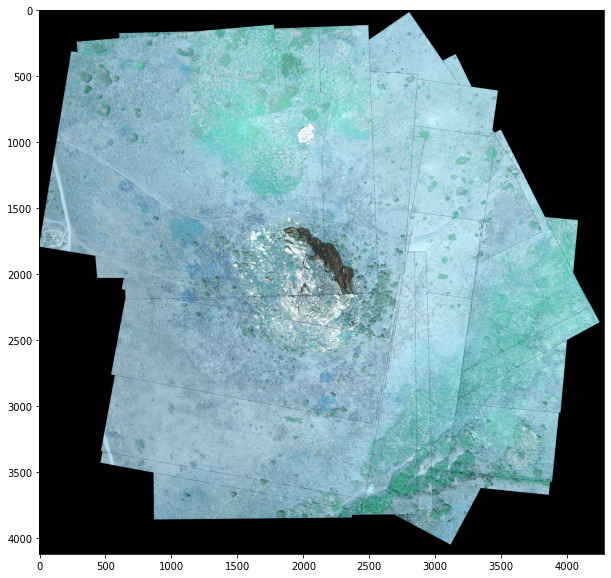

In [79]:
import numpy as np 
import cv2
import sys
from matchers import Matchers
import time
import matplotlib.pyplot as plt

class Stitch:
  def __init__(self, args): 
    self.path = '/content/txtlists/files1.txt'
    fp = open(self.path, 'r')
    filenames = [each.rstrip('\r\n') for each in fp.readlines()] 
    print(filenames)
    self.images = [cv2.resize(cv2.imread(each),(427, 320)) for each in filenames] 
    self.count = len(self.images)
    self.left_list, self.right_list, self.center_im = [], [],None
    self.matcher_obj = Matchers() 
    self.prepare_lists()

  def prepare_lists(self):
    print("Number of images : %d"%self.count) 
    self.centerIdx = self.count/2
    print("Center index image : %d"%self.centerIdx) 
    self.center_im = self.images[int(self.centerIdx)] 
    for i in range(self.count):
      if(i<=self.centerIdx): 
        self.left_list.append(self.images[i])
      else:
        self.right_list.append(self.images[i]) 
        print("Image lists prepared")

  def leftshift(self):
    # self.left_list = reversed(self.left_list)
    a = self.left_list[0]
    for b in self.left_list[1:]:
      H = self.matcher_obj.match(a, b, direction='left') 
      print("Homography is : ", H)
      xh = np.linalg.inv(H)
      print("Inverse Homography :", xh)
      ds = np.dot(xh, np.array([a.shape[1], a.shape[0], 1])); 
      ds = ds/ds[-1]
      print("final ds=>", ds)
      f1 = np.dot(xh, np.array([0,0,1])) 
      f1 = f1/f1[-1]
      xh[0][-1] += abs(f1[0])
      xh[1][-1] += abs(f1[1])
      ds = np.dot(xh, np.array([a.shape[1], a.shape[0], 1])) 
      offsety = abs(int(f1[1]))
      offsetx = abs(int(f1[0]))
      dsize = (int(ds[0])+offsetx, int(ds[1]) + offsety) 
      print("image dsize =>", dsize)
      tmp = cv2.warpPerspective(a, xh, dsize)
      # cv2.imshow("warped", tmp) # cv2.waitKey()
      tmp[offsety:b.shape[0]+offsety, offsetx:b.shape[1]+offsetx] = b 
      a = tmp

    self.leftImage = tmp

  def rightshift(self):
    for each in self.right_list:
      H = self.matcher_obj.match(self.leftImage, each, 'right') 
      print("Homography :", H)
      txyz = np.dot(H, np.array([each.shape[1], each.shape[0], 1]))
      txyz = txyz/txyz[-1]
      dsize = (int(txyz[0])+self.leftImage.shape[1],int(txyz[1])+self.leftImage.shape[0])
      tmp = cv2.warpPerspective(each, H, dsize) 
      plt.imshow(tmp)
      plt.show()
      #cv2.waitKey()
      # tmp[:self.leftImage.shape[0], :self.leftImage.shape[1]]=self.leftImage
      tmp = self.mix_and_match(self.leftImage, tmp)
      print("tmp shape",tmp.shape)
      print("self.leftimage shape=", self.leftImage.shape) 
      self.leftImage = tmp
      # self.showImage('left')

  def mix_and_match(self, leftImage, warpedImage): 
    i1y, i1x = leftImage.shape[:2]
    i2y, i2x = warpedImage.shape[:2] 
    print(leftImage[-1,-1])

    t = time.time()
    black_l = np.where(leftImage == np.array([0,0,0])) 
    black_wi = np.where(warpedImage == np.array([0,0,0])) 
    print(time.time() - t)
    print(black_l[-1])

    for i in range(0, i1x): 
      for j in range(0, i1y):
        try:
          if(np.array_equal(leftImage[j,i],np.array([0,0,0])) and np.array_equal(warpedImage[j,i],np.array([0,0,0]))):
            # print "BLACK"
            # instead of just putting it with black,
            # take average of all nearby values and avg it.
            warpedImage[j,i] = [0, 0, 0] 
          else:
            if(np.array_equal(warpedImage[j,i],[0,0,0])):
              # print "PIXEL"
              warpedImage[j,i] = leftImage[j,i] 
            else:
              if not np.array_equal(leftImage[j,i], [0,0,0]):
                bw, gw, rw = warpedImage[j,i] 
                bl,gl,rl = leftImage[j,i]
                # b = (bl+bw)/2
                # g = (gl+gw)/2 
                # r = (rl+rw)/2
                warpedImage[j, i] = [bl,gl,rl]
        except:
          pass
          # cv2.imshow("waRPED mix", warpedImage) 
          # cv2.waitKey()
    return warpedImage

  def trim_left(self): 
    pass

  def showImage(self, string=None): 
    if string == 'left':
      plt.imshow(self.leftImage)
      plt.show()
      # cv2.imshow("left image", cv2.resize(self.leftImage, (400,400)))
    elif string == "right": 
      plt.imshow(self.rightImage) 
      plt.show()
      #cv2.waitKey()

if  __name__ 	== '__main__': 
  try:
    args = sys.argv[1] 
  except:
    args = "txtlists/files1.txt"
  finally:
    print("Parameters : ", args) 
  s = Stitch(args)
  s.leftshift()
  # s.showImage('left')
  s.rightshift() 
  print("Done")
  cv2.imwrite("image_mosaic1.jpg", s.leftImage) 
  print("Image written") 
  #cv2.destroyAllWindows()

**This seems to perform the actual work of Orthomosaic**

Stitches all the images given to it within a textfile

<h2>Working on "Small Village" dataset</h2>

**Importing necessary packages**

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as pit 
import pandas as pd
from random import randrange 
import argparse
import glob

Giving/Supplying the required images

In [24]:
img1 = cv2.imread(r'/content/IMG_7747.JPG') 
img2 = cv2.imread(r'/content/IMG_7748.JPG') 
img3 = cv2.imread(r'/content/IMG_7749.JPG')

Re-sizing those images

In [26]:
img1 = cv2.resize(img1, (0,0), fx=1, fy=1) 
img2 = cv2.resize(img2, (0,0), fx=1, fy=1) 
img3 = cv2.resize(img3, (0,0), fx=1, fy=1)

In [27]:
def images_gray(img1,img2,img3):
  imglgray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY) 
  img2gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY) 
  img3gray = cv2.cvtColor(img3, cv2.COLOR_RGB2GRAY) 
  return imglgray,img2gray,img3gray

In [29]:
img1gray,img2gray,img3gray = images_gray(img1,img2,img3)

*Changing the color to GrayScale mode*

**Displaying all the 3 images**

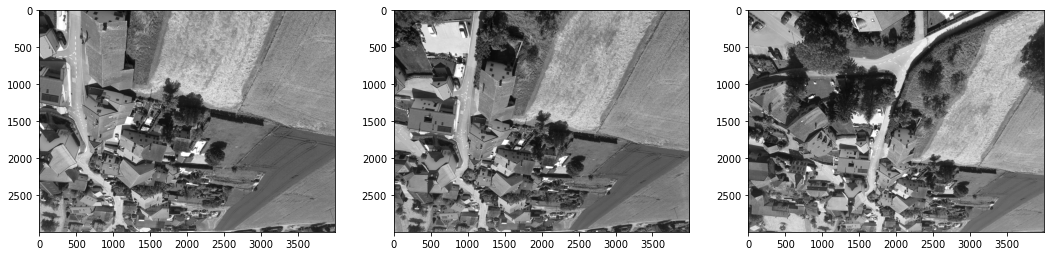

In [31]:
figure, ax = plt.subplots(1, 3, figsize=(18, 10))
ax[0].imshow(img1gray, cmap='gray') 
ax[1].imshow(img2gray, cmap='gray') 
ax[2].imshow(img3gray, cmap='gray')

**Using the ORB Algorithm**

In [33]:
orb = cv2.ORB_create()
#detect keypoints and extract
kp1,des1 = orb.detectAndCompute(img1, None) 
kp2,des2 = orb.detectAndCompute(img2, None) 
kp3,des3 = orb.detectAndCompute(img3, None)

In [34]:
keypoints_with_size1 = np.copy(img1)
keypoints_with_size2 = np.copy(img2)
keypoints_with_size3 = np.copy(img3)

Drawing the keypoints on one of the images given(here, 1st image)

In [35]:
cv2.drawKeypoints(img1, kp1, keypoints_with_size1, color=(0,255,0))

array([[[ 28,  33,  31],
        [ 28,  33,  31],
        [ 29,  34,  32],
        ...,
        [100, 148, 182],
        [ 93, 141, 175],
        [ 94, 142, 176]],

       [[ 28,  33,  31],
        [ 28,  33,  31],
        [ 29,  34,  32],
        ...,
        [ 93, 141, 175],
        [100, 148, 182],
        [109, 157, 191]],

       [[ 26,  32,  27],
        [ 27,  33,  28],
        [ 27,  33,  28],
        ...,
        [ 97, 142, 179],
        [108, 153, 190],
        [115, 160, 197]],

       ...,

       [[107, 150, 159],
        [108, 151, 160],
        [110, 153, 162],
        ...,
        [ 42,  36,  29],
        [ 42,  36,  29],
        [ 42,  36,  29]],

       [[103, 146, 155],
        [105, 148, 157],
        [110, 153, 162],
        ...,
        [ 40,  34,  27],
        [ 41,  35,  28],
        [ 44,  38,  31]],

       [[100, 143, 152],
        [105, 148, 157],
        [111, 154, 163],
        ...,
        [ 39,  33,  26],
        [ 41,  35,  28],
        [ 45,  39,  32]]

**Displaying the keypoints**

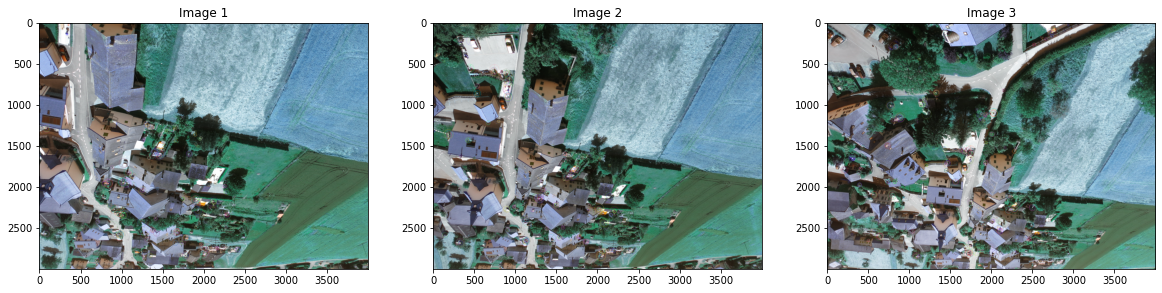

In [37]:
cv2.drawKeypoints(img1, kp1, keypoints_with_size1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) 
cv2.drawKeypoints(img2, kp2, keypoints_with_size2, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) 
cv2.drawKeypoints(img3, kp3, keypoints_with_size3, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) 
plt.figure(figsize=(20,10))
plt.subplot(1, 3, 1)
plt.title("Image 1") 
plt.imshow(keypoints_with_size1, cmap='gray') 
plt.subplot(1, 3, 2)
plt.title("Image 2") 
plt.imshow(keypoints_with_size2, cmap='gray') 
plt.subplot(1, 3, 3)
plt.title("Image 3") 
plt.imshow(keypoints_with_size3, cmap='gray')

In [38]:
print("keypoints: {}, descriptors: {}".format(len(kp1), des1.shape)) 
print("keypoints: {}, descriptors: {}".format(len(kp2), des2.shape)) 
print("keypoints: {}, descriptors: {}".format(len(kp3), des3.shape))

keypoints: 500, descriptors: (500, 32)
keypoints: 500, descriptors: (500, 32)
keypoints: 500, descriptors: (500, 32)


**Using the SIFT Algorithm**

In [39]:
sift = cv2.xfeatures2d.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1,None) 
kp2, des2 = sift.detectAndCompute(img2,None) 
kp3, des3 = sift.detectAndCompute(img3,None)

***Brute-Force (BF) Matcher***

In [40]:
match = cv2.BFMatcher()
matches = match.knnMatch(des1,des2,k=2)
print('Number of raw matches: %d.' % len(matches))

Number of raw matches: 185380.


Applying ratio test

In [41]:
good = [ ]
for m, n in matches:
  if m.distance < 0.7*n.distance : 
    good.append([m])
matches = np.asarray(good)

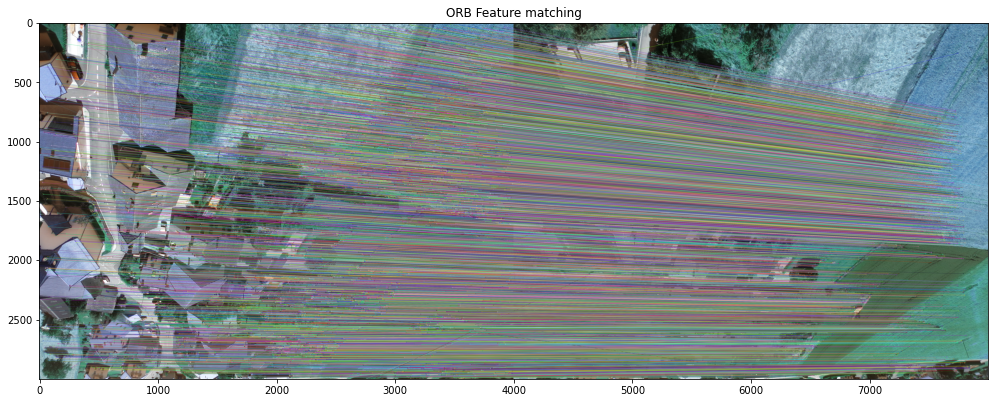

In [42]:
img4 =  cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,flags=2) 
plt.figure(figsize=(17,10))
plt.title("ORB Feature matching") 
plt.imshow(img4)

Finding the Homography

In [43]:
if len(matches[:,0]) >= 4:
  src = np.float32([ kp1[m.queryIdx].pt for m in matches[:,0] ]).reshape(-1,1,2) 
  dst = np.float32([ kp2[m.trainIdx].pt for m in matches[:,0] ]).reshape(-1,1,2) 
  H, masked = cv2.findHomography(src, dst, cv2.RANSAC, 5.0)
else:
  raise AssertionError("Can't find enough keypoints.")

Warping these images together

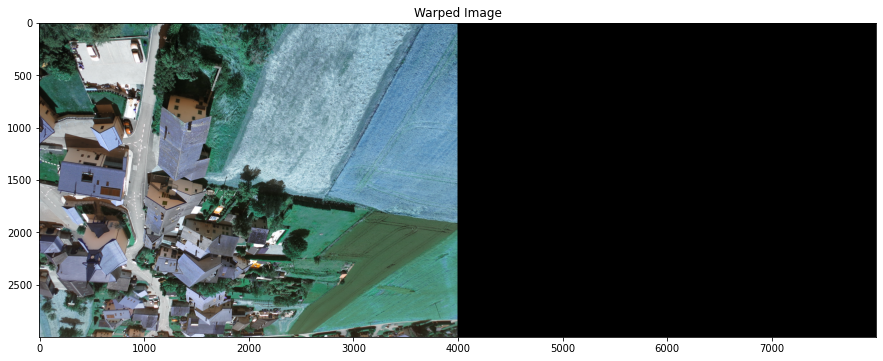

In [44]:
dst = cv2.warpPerspective(img1,H,(img2.shape[1] + img1.shape[1], img2.shape[0])) 
dst[0:img2.shape[0], 0:img2.shape[1]] = img2 
plt.figure(figsize=[15,10]),plt.title('Warped Image')
plt.imshow(dst) 
plt.show()

In [45]:
def crop(image):
  y_nonzero, x_nonzero, _ = np.nonzero(image)
  return image[np.min(y_nonzero):np.max(y_nonzero), np.min(x_nonzero):np.max(x_nonzero)]

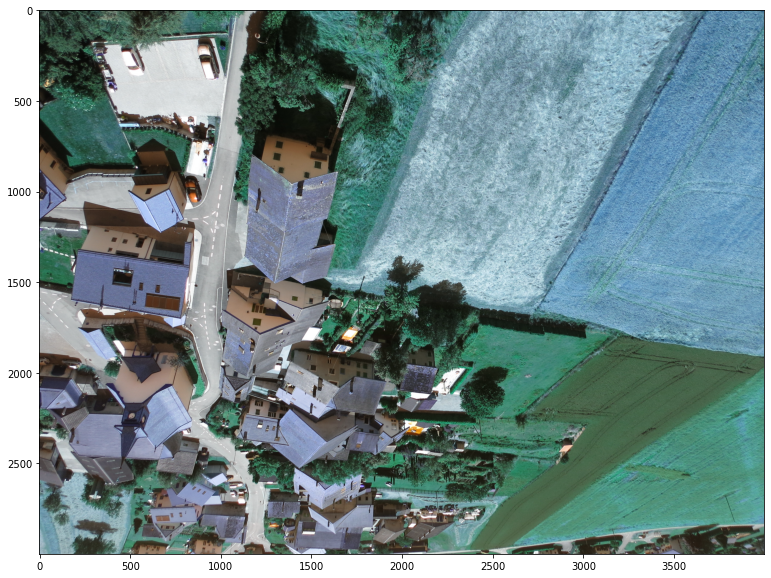

In [46]:
plt.figure(figsize=(15,10))
plt.imshow(crop(dst), cmap='gray')
output = crop(dst)

**After cropping the Warped images**

Detecting keypoints and descriptors for the 3rd image

In [47]:
sift = cv2.xfeatures2d.SIFT_create()

kp4, des4 = sift.detectAndCompute(output,None)

keypoints_with_size4 = np.copy(output)
cv2.drawKeypoints(output, kp4, keypoints_with_size4, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

array([[[ 66,  73,  68],
        [ 54,  61,  56],
        [ 44,  55,  47],
        ...,
        [ 96, 145, 171],
        [106, 155, 181],
        [114, 162, 186]],

       [[ 59,  70,  62],
        [ 60,  71,  63],
        [ 64,  75,  67],
        ...,
        [ 99, 149, 177],
        [105, 155, 183],
        [106, 155, 181]],

       [[ 54,  65,  57],
        [ 64,  75,  67],
        [ 71,  84,  76],
        ...,
        [ 98, 150, 180],
        [ 99, 151, 181],
        [ 97, 147, 175]],

       ...,

       [[167, 189, 201],
        [166, 188, 200],
        [164, 186, 198],
        ...,
        [ 58,  56,  46],
        [ 58,  56,  46],
        [ 59,  57,  47]],

       [[165, 187, 199],
        [164, 186, 198],
        [165, 187, 199],
        ...,
        [ 59,  57,  47],
        [ 60,  58,  48],
        [ 64,  62,  52]],

       [[164, 186, 198],
        [165, 187, 199],
        [167, 189, 201],
        ...,
        [ 60,  59,  49],
        [ 64,  63,  53],
        [ 69,  67,  57]]

####Comparing with the 3rd image

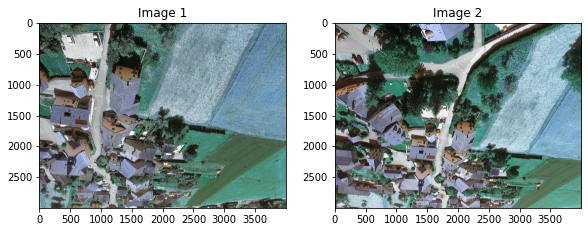

In [49]:
plt.figure(figsize=(15,10)) 
plt.subplot(1, 3, 1)
plt.title("Image 1") 
plt.imshow(keypoints_with_size4, cmap='gray') 
plt.subplot(1, 3, 2)
plt.title("Image 2") 
plt.imshow(keypoints_with_size3, cmap='gray')

In [50]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(des3,des4, k=2)
print("keypoints: {}, descriptors: {}".format(len(kp3), des3.shape)) 
print("keypoints: {}, descrlptors: {}".format(len(kp4), des4.shape))

keypoints: 159767, descriptors: (159767, 128)
keypoints: 172032, descrlptors: (172032, 128)


In [52]:
good = []
for m,n in matches:
  if m.distance < 0.7*n.distance: 
    good.append([m])
matches = np.asarray(good)

**SIFT Feature matching**

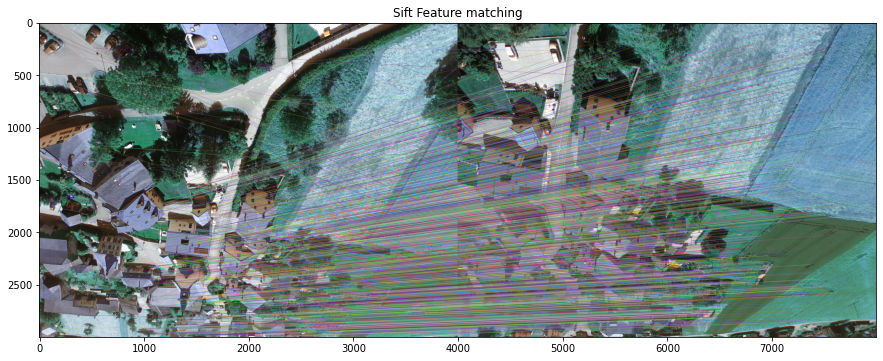

In [53]:
img5 = cv2.drawMatchesKnn(img3,kp3,output,kp4,matches,None,flags=2) 
plt.figure(figsize=(15,10))
plt.title("Sift Feature matching") 
plt.imshow(img5)

In [54]:
if len(matches[:,0]) >= 4:
  src = np.float32([ kp3[m.queryIdx].pt for m in matches[:,0] ]).reshape(-1,1,2) 
  dst = np.float32([ kp4[m.trainIdx].pt for m in matches[:,0] ]).reshape(-1,1,2) 
  H, masked = cv2.findHomography(src, dst, cv2.RANSAC, 5.0)
else:
  raise AssertionError("Can’t find enough keypoints.")

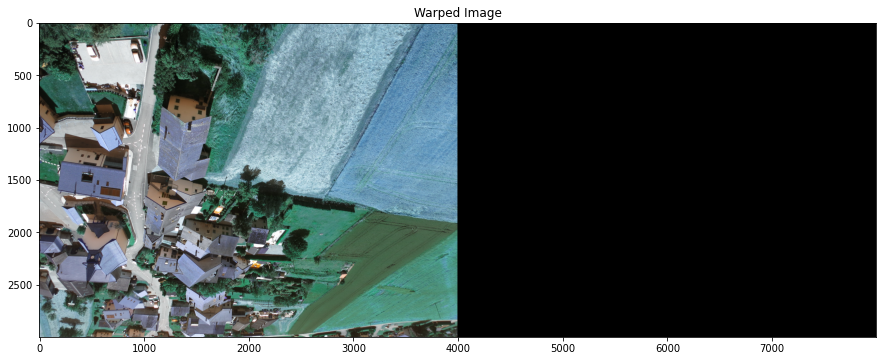

In [55]:
dst = cv2.warpPerspective(img3,H,(output.shape[1] + img3.shape[1], output.shape[0])) 
dst[0:output.shape[0], 0:output.shape[1]] = output 
plt.figure(figsize=[15,10]),plt.title('Warped Image')
plt.imshow(dst) 
plt.show()

Stitched/Warped image is generated, only croping is left

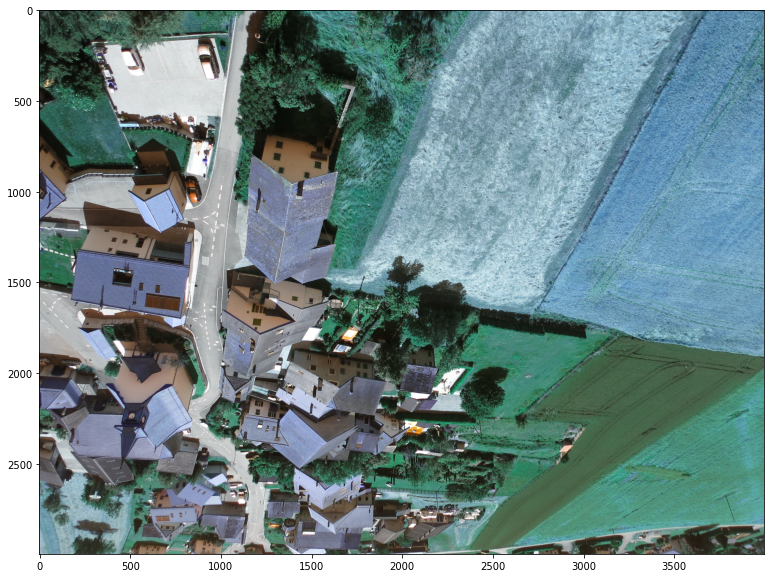

In [57]:
plt.figure(figsize=(15,10))
plt.imshow(crop(dst), cmap='gray')
output2 = crop(dst)

***The final image after stitching 3 images together to form an Orthomosaic***

This was another successful result.